<a href="https://colab.research.google.com/github/cwjng/si670-final-project/blob/main/si670_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# Git repo to clone
# git clone https://github.com/cwjng/si670-final-project.git

In [94]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, f1_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE

In [95]:
cmr_df = pd.read_csv("si670-final-project/cancer_mortality_rates.csv")
cmr_df.head()

,cmRate,population,medianIncome,pctPoverty,avgHouse,medianAge,medianAgeM,medianAgeF,pctHS,pctBach,...,pctBlack,pctAsian,pctOther,rmRace,pctMarried,pctMarriedHouse,birthRate,region,state,county
0,191.2,25859,38013,18.6,2.28,45.4,44.6,46.2,36.4,7.9,...,4.925408,0.338357,0.065365,white,62.1,57.173258,4.687790,Southeast,Alabama,Cherokee County
1,187.9,82005,39922,17.2,2.55,40.5,39.4,41.9,34.7,9.1,...,1.190638,0.557031,0.737356,white,57.6,54.850257,3.913309,Southeast,Alabama,Cullman County
2,217.4,41131,26602,35.2,2.53,38.7,36.2,40.0,34.6,8.2,...,69.184419,0.341605,0.161313,black,33.4,30.987632,8.433257,Southeast,Alabama,Dallas County
3,193.8,81468,54298,14.4,2.65,37.9,36.7,39.1,35.4,13.4,...,21.218875,0.516326,0.678529,white,51.0,54.326202,5.800147,Southeast,Alabama,Elmore County
4,205.8,16759,35664,20.6,2.36,43.2,41.3,46.1,38.8,8.4,...,12.387547,0.390625,0.000000,white,53.6,51.499218,5.730897,Southeast,Alabama,Fayette County


In [96]:
# corr_matrix = cmr_df.drop(columns=["rmRace", "region",
#                      "state", "county"]).corr()

In [97]:
corr = cmr_df["pctMarried"].corr(cmr_df["pctMarriedHouse"])
print("Correlation:", corr)

Correlation: 0.8487861233872582


# Add Labels to Data for Classification

Adding labels to perform a classification task that predicts Low/Medium/High levels of cancer mortality

In [98]:
# Run K-means on cmRate only to define clusters and assign labels
kmeans = KMeans(n_clusters=3, random_state=42)
cmr_df["cluster_raw"] = kmeans.fit_predict(cmr_df[["cmRate"]])

# Sort clusters by actual mean cmRate
# Cluster 0 = low, 1 = medium, 2 = high)
cluster_order = (
    cmr_df.groupby("cluster_raw")["cmRate"]
    .mean()
    .sort_values()
    .index
)

# Mapping raw clusters → ordered levels (0=low, 1=med, 2=high)
cluster_map = {old: new for new, old in enumerate(cluster_order)}
cmr_df["cmClass"] = cmr_df["cluster_raw"].map(cluster_map)

cmr_df = cmr_df.drop(columns=["cluster_raw"])
print(cmr_df["cmClass"].value_counts())
county_labels = cmr_df[["county", "state", "cmRate", "cmClass"]]
county_labels.head()


cmClass
1    263
0    142
2    132
Name: count, dtype: int64


,county,state,cmRate,cmClass
0,Cherokee County,Alabama,191.2,1
1,Cullman County,Alabama,187.9,1
2,Dallas County,Alabama,217.4,2
3,Elmore County,Alabama,193.8,1
4,Fayette County,Alabama,205.8,2


## Visualizing Cancer Mortality Levels

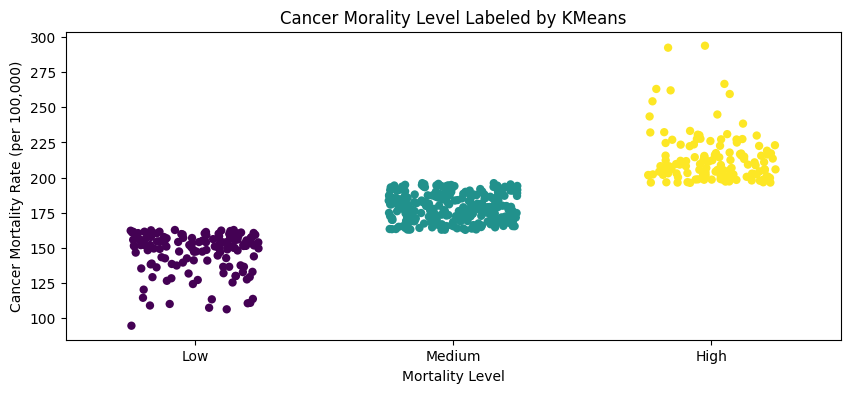

In [99]:
plt.figure(figsize=(10, 4))
sns.stripplot(
    data=cmr_df,
    x="cmClass",
    y="cmRate",
    hue="cmClass",
    palette="viridis",
    jitter=0.25,
    size=6,
    legend=False
)

plt.title("Cancer Morality Level Labeled by KMeans")
# plt.legend(title="Level", labels=label_map.values())
plt.xticks([0, 1, 2], ["Low", "Medium", "High"])
plt.xlabel("Mortality Level")
plt.ylabel("Cancer Mortality Rate (per 100,000)")
plt.show()

# Preprocess

In [100]:
X = cmr_df.drop(columns=["cmRate", "cmClass", "medianAgeM",
                         "medianAgeF", "pctMarriedHouse", "rmRace"])
y = cmr_df["cmClass"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

Attempted a log transformation on variables that had a right-skewed distribution, but this didn't improve the performance of the model

In [101]:
# Log Transformation

# log_transform_cols = ["population", "medianIncome", "pctPoverty"]
# Create a pipeline for numeric features
# numeric_pipeline = Pipeline([
#     # Log-transform selected features
#     ("log", ColumnTransformer([
#         ("log_features", FunctionTransformer(np.log1p, validate=True), log_transform_cols)
#     ], remainder="passthrough")),  # keep other numeric features unchanged
#     ("scaler", StandardScaler())
# ])

In [102]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

# SMOTE oversample on minority classes
smote = SMOTE(sampling_strategy="not majority", random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

# Model Selection


Fitting preprocessed data to various models to see which ones perform best at their baseline </br></br>
**Models Used**: Logistic Regression, Random Forest, SVM (RBF kernel), KNN, Gradient Boost

In [103]:
# Logistic Regression
log_clf = LogisticRegression(
    multi_class="multinomial",
    max_iter=2000
)
log_clf.fit(X_train_res, y_train_res)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced"
)
rf_clf.fit(X_train_res, y_train_res)

# SVM
svm_clf = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced"
)
svm_clf.fit(X_train_res, y_train_res)

# kNN
knn_clf = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)
knn_clf.fit(X_train_res, y_train_res)

# Gradient Boost
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GradientBoostingClassifier(random_state=42)

In [104]:
models = {
    "Logistic Regression": log_clf,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
    "SVM (RBF)": svm_clf,
    "KNN": knn_clf
}

for name, model in models.items():
    preds = model.predict(X_test_proc)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Macro F1:", f1_score(y_test, preds, average="macro"))
    print("Weighted F1:", f1_score(y_test, preds, average="weighted"))
    print(classification_report(y_test, preds))


=== Logistic Regression ===
Accuracy: 0.5648148148148148
Macro F1: 0.566761658886629
Weighted F1: 0.5639858182939776
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        29
           1       0.61      0.51      0.56        53
           2       0.53      0.65      0.59        26

    accuracy                           0.56       108
   macro avg       0.56      0.58      0.57       108
weighted avg       0.57      0.56      0.56       108


=== Random Forest ===
Accuracy: 0.6296296296296297
Macro F1: 0.6209025439227112
Weighted F1: 0.6280066579500913
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        29
           1       0.65      0.66      0.65        53
           2       0.58      0.69      0.63        26

    accuracy                           0.63       108
   macro avg       0.63      0.62      0.62       108
weighted avg       0.63      0.63      0.63       108


=== Gr

# Grid Search for Parameter Tuning

Setting up parameters for each model to search through </br></br>
**Models Used**: Random Forest, Gradient Boost, SVM (RBF kernel), KNN, Logistic Regression, Linear SVC

In [105]:
# Random Forest
rf_params = {
    "n_estimators": [200, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# Gradient Boosting
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}

# SVM
svm_params = {
    "C": [1, 5, 10],
    "gamma": ["scale", 0.1, 0.01]
}

# KNN
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]
}

# Logistic Regression
log_params = {
    "penalty": ["l2"],
    "C": [0.01, 0.1, 1, 5, 10, 50],
    "solver": ["lbfgs"],
    "max_iter": [2000]
}

# Linear SVC
linsvc_params = {
    "C": [0.01, 0.1, 1, 5, 10, 50],
    "loss": ["squared_hinge"],
    "max_iter": [5000],
    "class_weight": ["balanced"]
}

In [106]:
# Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    rf_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best RF:", rf_grid.best_params_)

# Gradient Boosting
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
gb_grid.fit(X_train_res, y_train_res)
best_gb = gb_grid.best_estimator_
print("Best GB:", gb_grid.best_params_)

# SVM
svm_grid = GridSearchCV(
    SVC(kernel="rbf", probability=True, class_weight="balanced"),
    svm_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)
svm_grid.fit(X_train_res, y_train_res)
best_svm = svm_grid.best_estimator_
print("Best SVM:", svm_grid.best_params_)

# KNN
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

knn_grid.fit(X_train_proc, y_train)
best_knn = knn_grid.best_estimator_
print("Best KNN Parameters:", knn_grid.best_params_)

# Logistic Regression
log_grid = GridSearchCV(
    LogisticRegression(
        class_weight="balanced",
        multi_class="auto"
    ),
    log_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

log_grid.fit(X_train_res, y_train_res)
best_log = log_grid.best_estimator_
print("Best Logistic Regression Params:", log_grid.best_params_)

# Linear SVC
linsvc_grid = GridSearchCV(
    LinearSVC(),
    linsvc_params,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

linsvc_grid.fit(X_train_res, y_train_res)
best_linsvc = linsvc_grid.best_estimator_
print("Best LinearSVC Params:", linsvc_grid.best_params_)


Best RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best GB: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best SVM: {'C': 10, 'gamma': 0.1}
Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Logistic Regression Params: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LinearSVC Params: {'C': 5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 5000}


# Comparing Stacking vs. Voting Classifier Using Best Parameters

Assessing performance using different combinations of models and ensemble methods on the training data (with SMOTE resampling) by using their best parameters found through the GridSearch.



## Stacking Classifier


*   RF and KNN perform the best
*   RF and GB doesn't show any improvement from just running RF by itself
*   RF and SVM are a bad commbo because it reduces the F1 score a lot for each class

In [107]:
stack = StackingClassifier(
    estimators=[
        ("rf", best_rf),
        ("knn", best_knn), # KNN has imbalance though
        ("logreg", best_log),
        # ("svm_linear", LinearSVC(class_weight="balanced"))
        # ("gb", best_gb), # GB doesn't improve anything nor decrease
        # ("svm", best_svm) # SVM doesn't work well and reduces the F1 score
    ],
    final_estimator=LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        multi_class="auto"
    ),
    stack_method="predict_proba",
    n_jobs=-1
)

stack.fit(X_train_res, y_train_res)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=400,
                                                       random_state=42)),
                               ('knn',
                                KNeighborsClassifier(metric='euclidean', p=1)),
                               ('logreg',
                                LogisticRegression(C=10,
                                                   class_weight='balanced',
                                                   max_iter=2000,
                                                   multi_class='auto'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=2000,
                                                      multi_class='auto'),
                   n_jobs=-1, stack_method='predict_proba')

In [108]:
y_pred = stack.predict(X_test_proc)

print("STACKED MODEL")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

STACKED MODEL
Accuracy: 0.6018518518518519
Macro F1: 0.5860805860805861
Weighted F1: 0.597883597883598
              precision    recall  f1-score   support

           0       0.57      0.45      0.50        29
           1       0.61      0.68      0.64        53
           2       0.62      0.62      0.62        26

    accuracy                           0.60       108
   macro avg       0.60      0.58      0.59       108
weighted avg       0.60      0.60      0.60       108



## Voting Classifier


*   RF, LR, SVM, and KNN perform the best since it seems to predict all classes equally (F1score = 0.67/68)
*   RF and GB predicts some classes better than others (imbalance)
*   Hard voting performs better than soft voting
*   RF, SVM, KNN, and GB with hard voting does pretty well but has a lot of imbalance



In [109]:
voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_rf),
        ("knn", best_knn),
        ("logreg", best_log),
        # ("gb", best_gb),
        # ("svm_linear", best_linsvc), # Doesn't perform as well compared to log reg
        ("svm", best_svm)
    ],
    voting="hard", # Hard voting is slightly better than soft
    n_jobs=-1
)

voting_clf.fit(X_train_res, y_train_res)

preds = voting_clf.predict(X_test_proc)

print("Voting Classifier")
print("Accuracy:", accuracy_score(y_test, preds))
print("Macro F1:", f1_score(y_test, preds, average="macro"))
print("Weighted F1:", f1_score(y_test, preds, average="weighted"))
print(classification_report(y_test, preds))

Voting Classifier
Accuracy: 0.6759259259259259
Macro F1: 0.6745658906636044
Weighted F1: 0.6759065935128155
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        29
           1       0.70      0.66      0.68        53
           2       0.68      0.65      0.67        26

    accuracy                           0.68       108
   macro avg       0.67      0.68      0.67       108
weighted avg       0.68      0.68      0.68       108



## Insights from Stacking vs. Voting Classifier

*   Voting classifer is better at evenly predicting all classes
*   Stacking classifier has a harder time predicting class 0 but predicts class 1 pretty well